# Welcome to the -- Tutorial!

This Notebook calculate the scattering & intrinsic absorption parameters of the Rayleigh waves following the instruction proposed by Hirose et al. (2019).

## **Publication about this script**:
Hirose, T., Nakahara, H., & Nishimura, T. (2019). A passive estimation method of scattering and intrinsic absorption parameters from envelopes of seismic ambient noise cross‐correlation functions. Geophysical Research Letters, 46(7), 3634-3642. https://doi.org/10.1029/2018GL080553




Step: <br>
0) Filtering <br> 1) Calculation of mean-squared (MS) envelopes <br> 2) Selection of MS envelopes by SNR (e.g. inter-station distances <10 km and SNR>3) <br>
3) Selection of observed energy densities <br>
4) Calculation of synthesized energy densities via a grid search <br>
--- The search range of l (b) was between 0.4 and 10 km (0.00–0.40 s−1) with an increment of 0.1 km (0.02 s−1) <br>
5) Determination of best-fit parameters <br>

In [1]:
#from noisepy.seis.asdfstore import ASDFCCStore, ASDFStackStore          # Object to store ASDF data within noisepy
import os
import sys
import glob
import obspy

#import h5py
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyasdf
import scipy

from obspy.signal.filter import bandpass

In [2]:
path = "./" 
data_path = os.path.join(path, "STACK_HH_rma")
sfiles = sorted(glob.glob(os.path.join(data_path, '**/*.h5')))

#data_path = os.path.join(path, "CCF")
#sfiles = sorted(glob.glob(os.path.join(data_path, '*.h5')))
print(sfiles)


['./STACK_HH_rma/UW.H2O/UW.H2O_UW.H2O.h5', './STACK_HH_rma/UW.H2O/UW.H2O_UW.LIGO.h5', './STACK_HH_rma/UW.H2O/UW.H2O_UW.NIKE.h5', './STACK_HH_rma/UW.LIGO/UW.LIGO_UW.LIGO.h5', './STACK_HH_rma/UW.LIGO/UW.LIGO_UW.NIKE.h5', './STACK_HH_rma/UW.NIKE/UW.NIKE_UW.NIKE.h5']


## Read in HDF5 files

In [ ]:
#for ncmp in range(1):
#    print("\n",files[ncmp],"\n")
#    with h5py.File(files[ncmp],'r') as fh5:
#        print(list(fh5.keys()))
#        wav=fh5['Waveforms']
#        aux=fh5['AuxiliaryData']
#        print(type(wav),"\n")
#        print("data: {}".format(wav))

3
(3, 2, 2001)
continue! no ZR component exist
working on ./STACK_HH_rma/UW.H2O/UW.H2O_UW.LIGO.h5 that is  7.37km apart. dt: 0.050000 
working on ./STACK_HH_rma/UW.H2O/UW.H2O_UW.NIKE.h5 that is  8.36km apart. dt: 0.050000 
continue! no ZR component exist
working on ./STACK_HH_rma/UW.LIGO/UW.LIGO_UW.NIKE.h5 that is 11.76km apart. dt: 0.050000 
continue! no ZR component exist


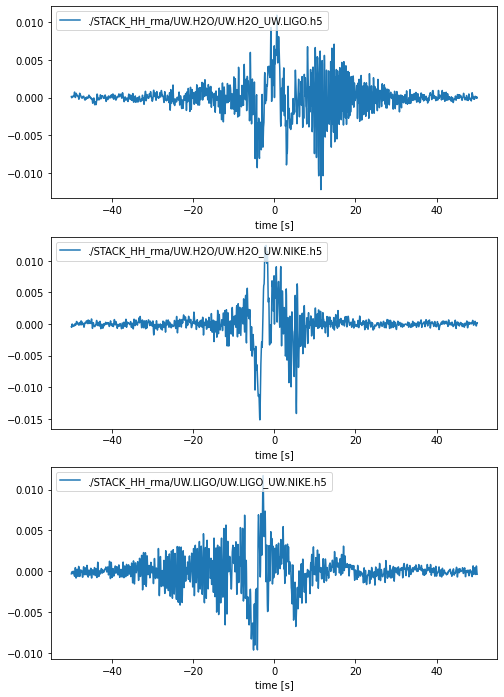

In [3]:
fnum=3 #len(sfiles)
print(fnum)

fig, ax = plt.subplots(fnum, figsize=(8, 12), sharex=False)

aa=0
stackf=np.ndarray((fnum,2,2001))
print(stackf.shape)
fname=[]
vdist=np.zeros((fnum,1))

# common parameters
ccomp = "ZR"
lag=50

# loop through each station-pair
for sfile in sfiles:
    # useful parameters from each asdf file
    with pyasdf.ASDFDataSet(sfile, mode="r") as ds:
        #print(ds,"\n")
        alist = ds.auxiliary_data.list()
        try:
            dt = ds.auxiliary_data[alist[0]][ccomp].parameters["dt"]
            dist = ds.auxiliary_data[alist[0]][ccomp].parameters["dist"]
            #npts = ds.auxiliary_data[alist[0]][ccomp].parameters["npts"]            
        except Exception:
            print("continue! no %s component exist" % ccomp)
            continue
        print("working on %s that is %5.2fkm apart. dt: %f " % (sfile, dist,dt))

        # stacked data and filter it
        sdata = ds.auxiliary_data[alist[0]][ccomp].data[:]
        para = ds.auxiliary_data[alist[0]][ccomp].parameters
        
        # time domain variables
        nwin = len(alist[1:])
        npts = sdata.size
        tvec = np.arange(-npts // 2 + 1, npts // 2 + 1) * dt
        indx = np.where(np.abs(tvec) <= lag)[0]
        tvec = np.arange(-npts // 2 + 1, npts // 2 + 1) * dt
    
    stackf[aa]=[tvec,sdata]
    vdist[aa]=dist
    fname.append(sfile.split("/")[3])
    ### stacked waveforms
    ax[aa].plot(tvec, sdata)
    ax[aa].legend([sfile], loc="upper left")
    ax[aa].set_xlabel("time [s]")
    aa=aa+1

#fig.tight_layout()
#plt.show()

### Step 0 --- Filtering

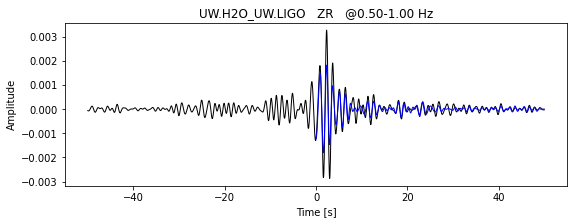

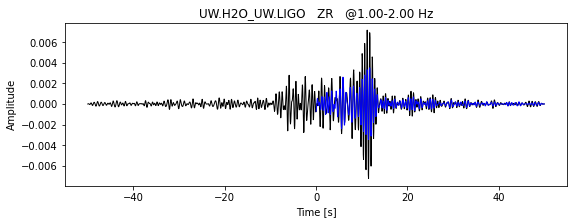

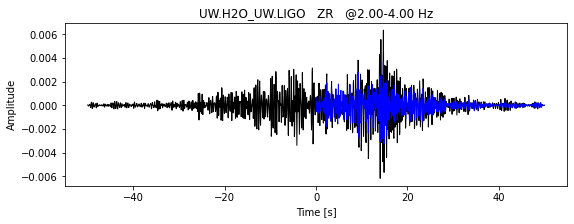

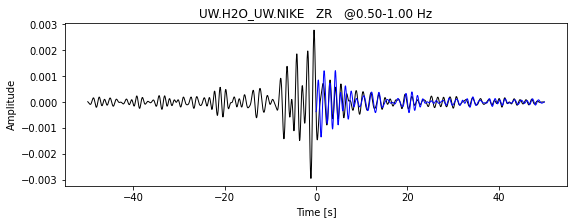

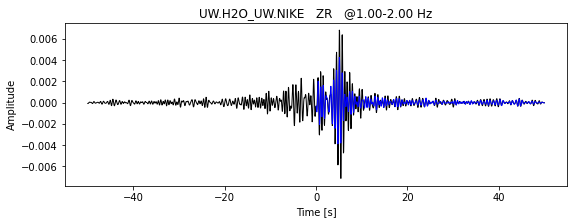

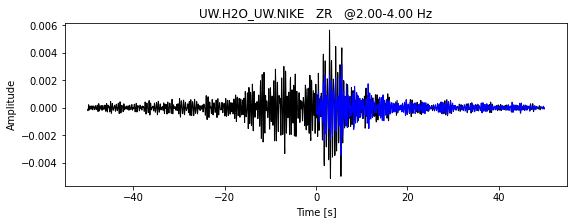

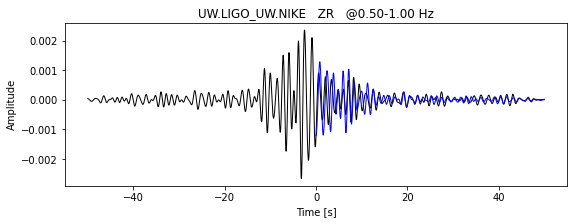

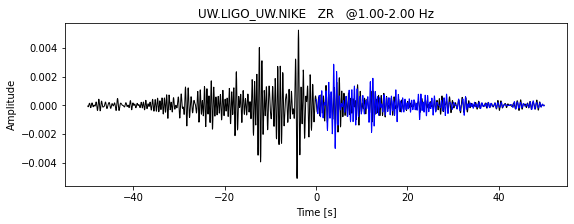

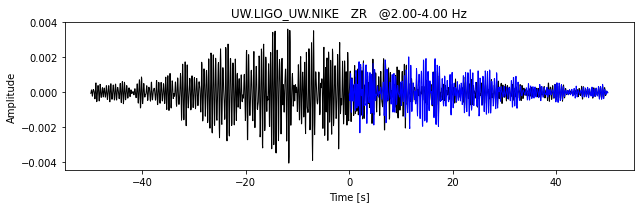

In [4]:
freq = [0.5, 1, 2, 4]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1

indx = npts // 2 
MSE=np.ndarray((fnum,nfreq+1,indx+1))
data_sym=np.ndarray((nfreq+1,indx+1))

for aa in range (fnum):
    dafbp=np.ndarray((nfreq,npts))
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        tt = np.arange(0, npts) * dt
        data = stackf[aa][1]
        dafbp[fb] = bandpass(data, fmin, fmax, int(1 / dt), corners=4, zerophase=True)
        

        # stack positive and negative lags  
        sym = 0.5 * dafbp[fb][indx:] + 0.5 * np.flip(dafbp[fb][: indx + 1], axis=0)
        data_sym[fb]=sym
        plt.figure(figsize=(9, 3))
        plt.plot(stackf[aa][0], dafbp[fb], "k-", linewidth=1)
        plt.plot(stackf[aa][0][indx:], data_sym[fb], "b-", linewidth=1)
        plt.title(
            "%s   %s   @%4.2f-%4.2f Hz"
            % (
                fname[aa].split(".h5")[0],
                ccomp,
                fmin,
                fmax,
                )
            )
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
    MSE[aa]=[stackf[aa][0][indx:],data_sym[0],data_sym[1],data_sym[2]]
plt.tight_layout()
plt.show()

### Step 1 --- Calculation of mean-squared (MS) envelopes --> ***Eobs***  <br>
**need to add coda normalization** <br>
*/"The summed MS envelope was then normalized using their values at lapse times greater than twice the arrival times of direct Rayleigh waves for farthest station pairs (coda normalization)"*

--> normalized MS envelope is referred to as the observed energy density Eobs 

In [5]:
#Python3 program to calculate Mean Square
import math
#Function that Calculate Mean Square
def msValue(arr, n):
    square = 0
    mean = 0.0
    
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean
    mean = square / (float)(n)
    
    return mean

(3, 4, 1001)


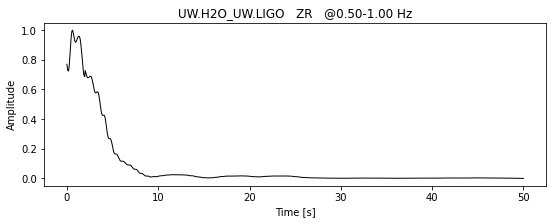

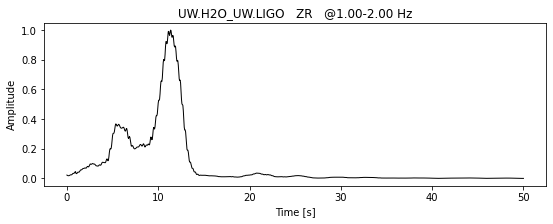

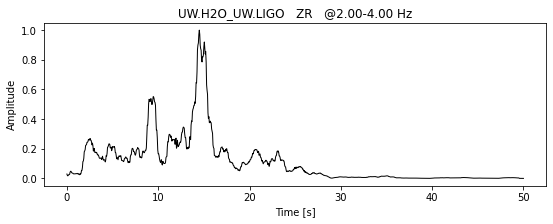

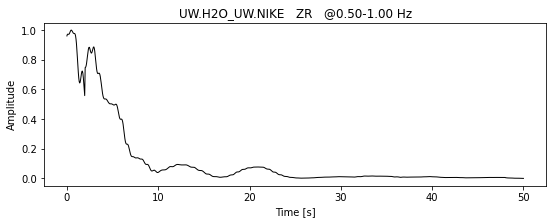

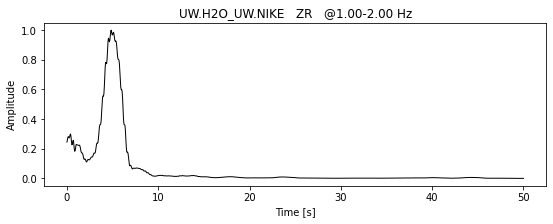

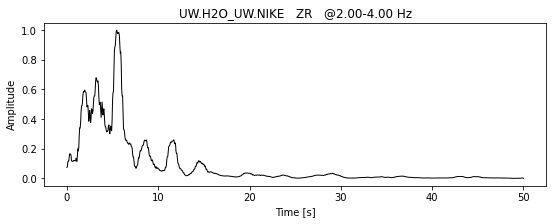

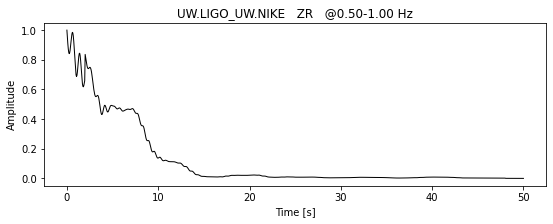

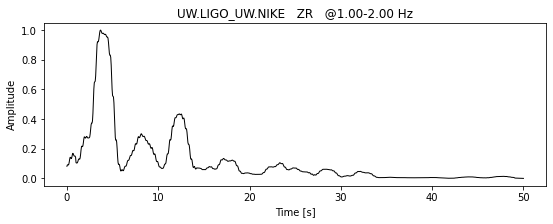

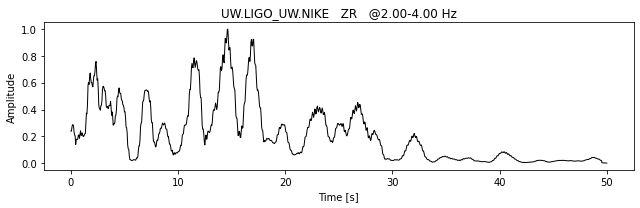

In [6]:
msv=np.ndarray((fnum,nfreq+1,indx+1))
msv[:][:][:]=0.
print(msv.shape)

winlen=[4,2,1]   # smoothing window lengths corresponding to the frequency bands
for aa in range(fnum):
    msv[aa][0]=MSE[aa][0][:]
    for fb in range(nfreq):
        data=MSE[aa][fb+1][:]
        fmin=freq[fb]
        fmax=freq[fb+1]
        
        # small window smoothing
        npt=int(winlen[fb]/dt)+1
        half_npt=int(npt/2)
        arr=np.zeros(int(npt))
        for jj in range(0, (npts//2)):
            if jj < half_npt:
                arr=data[jj: jj+half_npt]
            elif jj > (npts//2)-half_npt:
                arr=data[jj: npts]
            else:
                arr=data[jj-half_npt : jj+half_npt]
            msv[aa][fb+1][jj] = msValue(arr,len(arr))
        
        msv[aa][fb+1]=msv[aa][fb+1]/np.max(msv[aa][fb+1])  # self-normalized --> need to be updated by coda normalization
        plt.figure(figsize=(9, 3))
        plt.plot(msv[aa][0][:], msv[aa][fb+1], "k-", linewidth=1)
        plt.title(
            "%s   %s   @%4.2f-%4.2f Hz"
            % (
                fname[aa].split(".h5")[0],
                ccomp,
                fmin,
                fmax,
                )
            )
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

### Step 2 ---  Selection of MS envelopes by SNR (e.g. inter-station distances <10 km and SNR>3) 


### Step 3 --- Selection of observed energy densities 

### Step 4 --- Calculation of synthesized energy densities via a grid search 
### #The 2-D radiative transfer equation for scalar waves  ***(Shang and Gao 1988; Sato 1993)***
Assuming isotropic scattering and source radiation in infinite medium to calculate ***synthesized energy densities  Esyn*** :

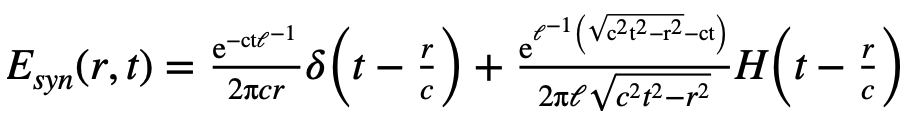

* l scattering mean free paths 
* c is the Rayleigh wave velocity
* r is the distance between the source and receiver
* H is the Heaviside function

* ### ***b is intrinsic absorption parameter***


In [15]:
# Dirac delta function
def impulse(x):
    return 1 * (x == 0)  

# Heaviside function (step function)
def step(x):
    return 1 * (x > 0)

# Esyn -->The 2-D radiative transfer equation for scalar waves 
def ESYN_RadiaTrans(mean_free,tm, r, c):
       
    s0=c**2 * tm**2 -r**2
    if s0 > 0:
        # first term
        a1up=math.exp(-1 * c * tm * (mean_free**(-1)))
        a1bot= 2 * math.pi * c * r
        #first= (a1up/a1bot)* scipy.signal.unit_impulse( tm-r/c ,'mid')
        first= (a1up/a1bot)* impulse( tm-r/c )
        
        # second term
        ind2=mean_free**(-1) * (math.sqrt(s0)-c*tm)
        a2up=math.exp(ind2)
        a2bot=2 * math.pi * mean_free * math.sqrt(s0)
        #second=(a2up)/(a2bot)* math.heaviside(tm-r/c)
        second=(a2up/a2bot)* step(tm-r/c)
        
        #print("A1: %.4f %.4f %.4f " % ((a1up/a1bot),a1up,a1bot),"  , A2: %.4f %.4f %.4f " % ((a2up/a2bot),a2up,a2bot))    
        Esyn= first + second
    
        return Esyn

The sum of squared residuals (SSR) between Eobs and Esyn was calculated, and the values of the parameters l and b that minimize SSR through the grid search were determined.

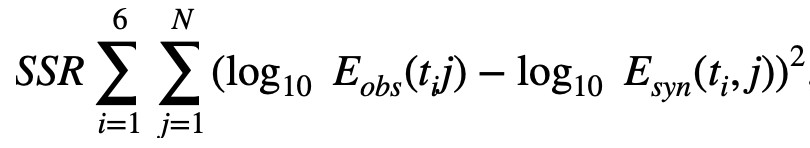

<ipython-input-20-f1333dba8ab0>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 3))


0 0 (3, 3, 60, 40) 1.0 3.126457310772186e-08 0
0 1 (3, 3, 60, 40) 1.0 9.003122071492793e-10 0
0 2 (3, 3, 60, 40) 1.0 9.81461239911698e-09 0


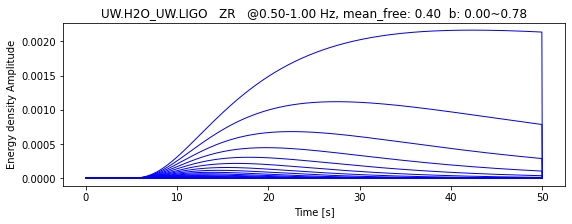

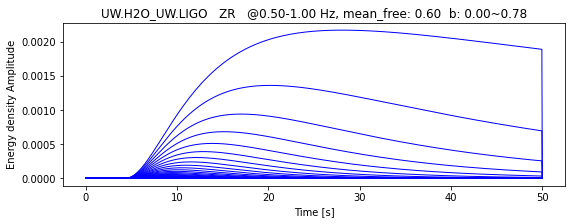

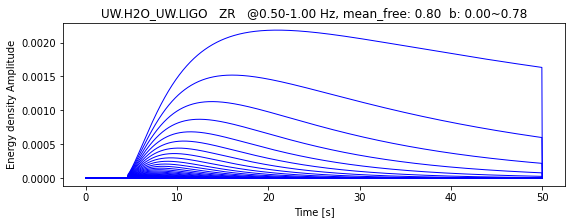

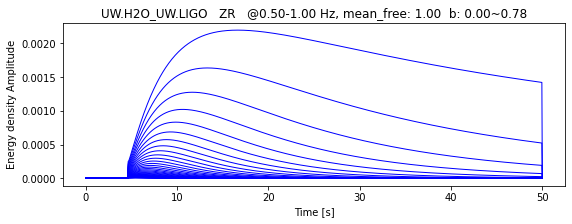

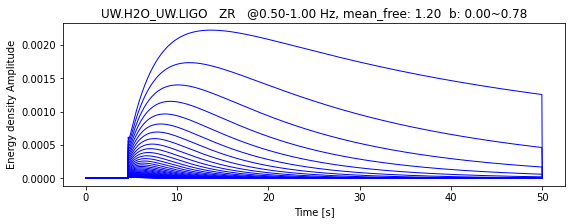

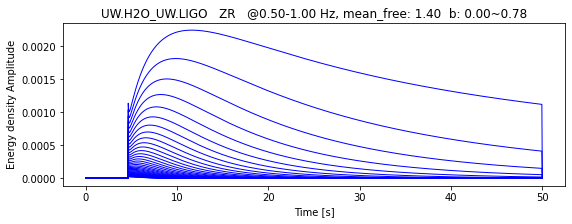

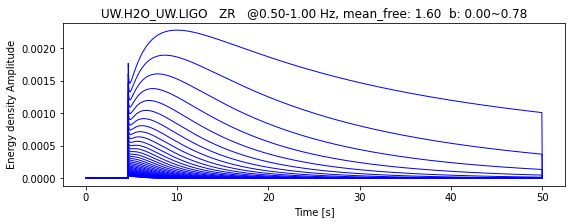

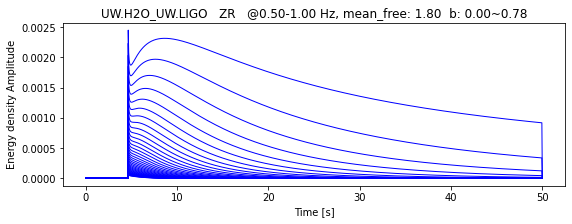

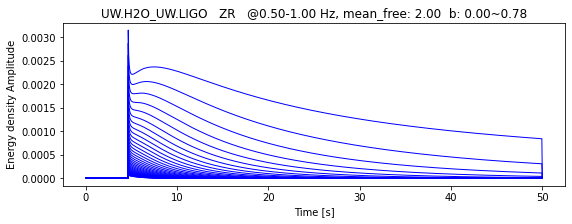

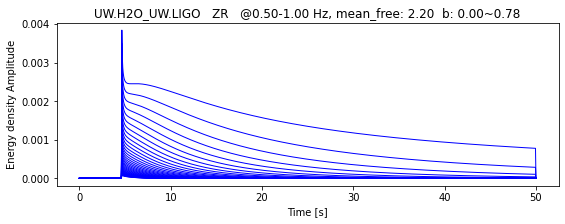

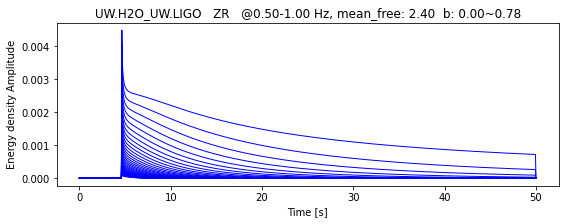

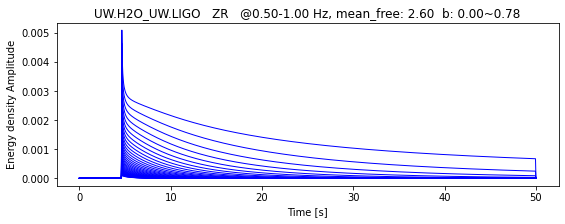

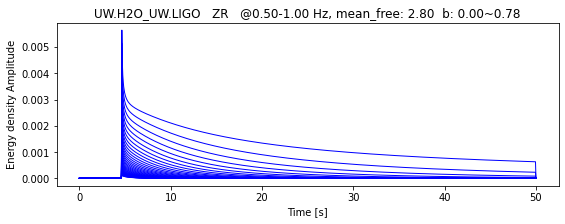

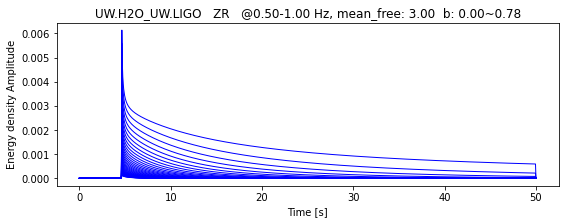

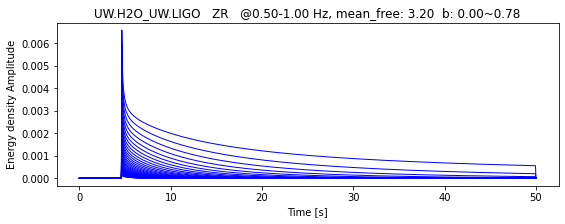

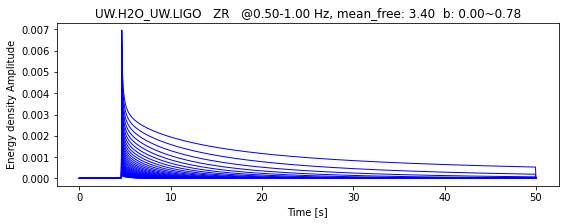

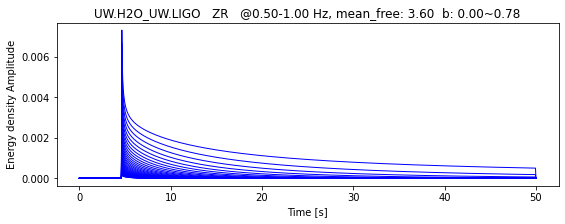

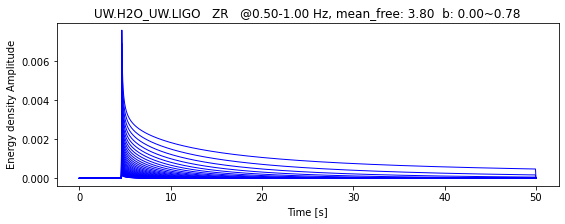

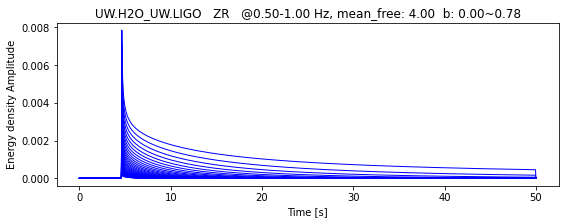

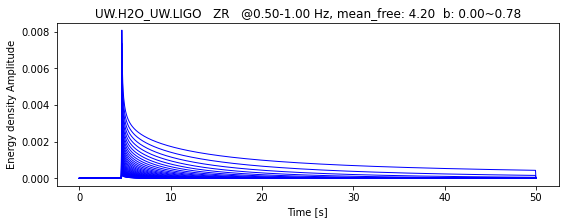

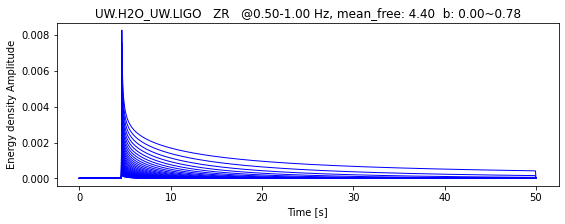

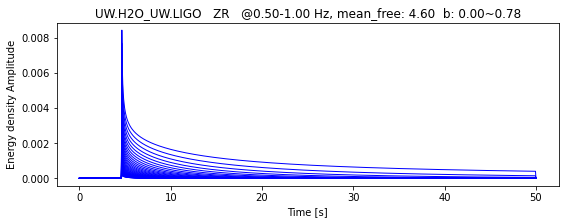

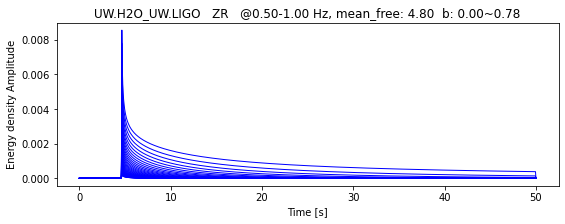

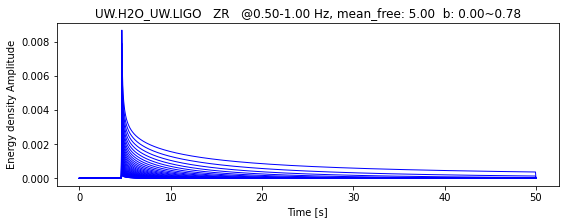

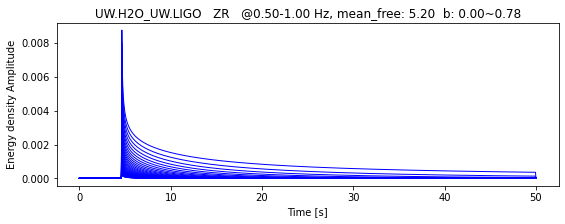

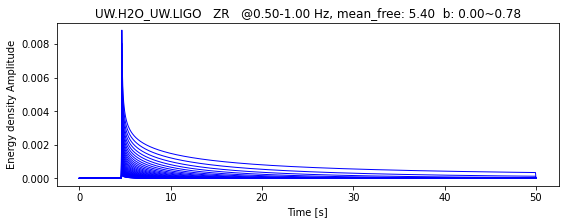

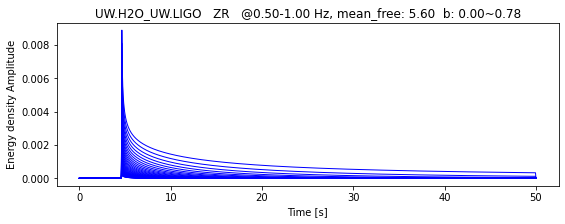

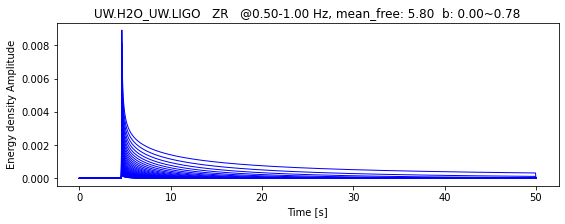

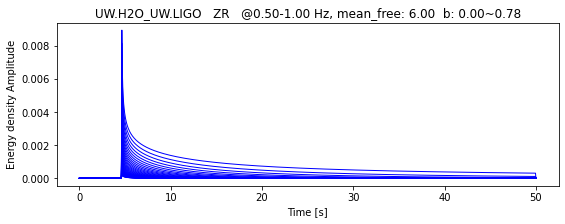

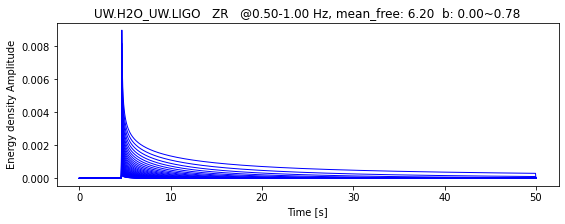

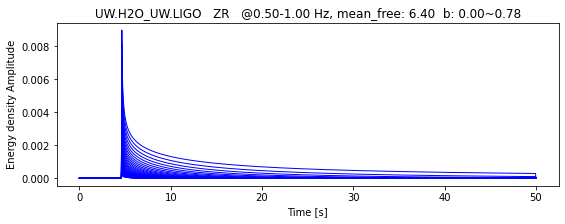

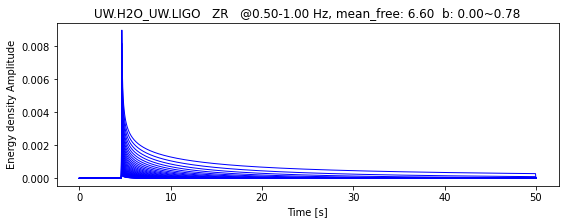

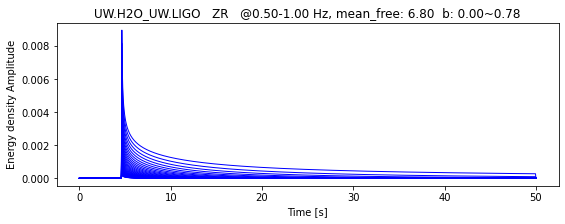

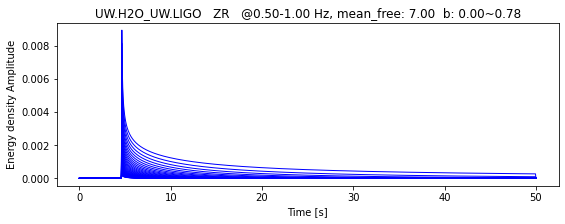

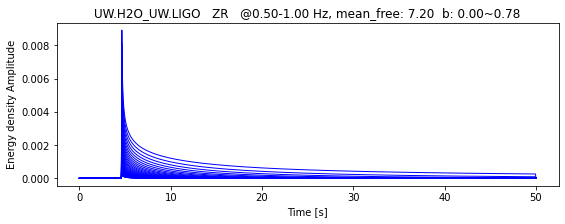

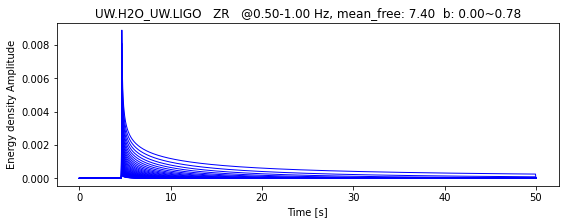

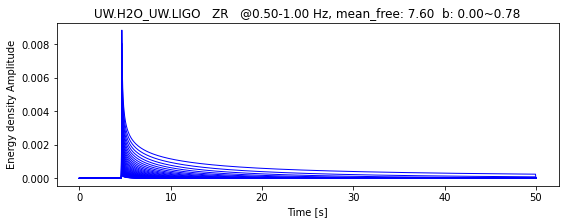

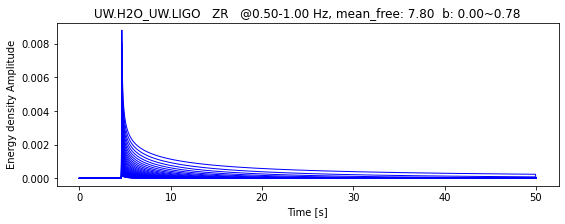

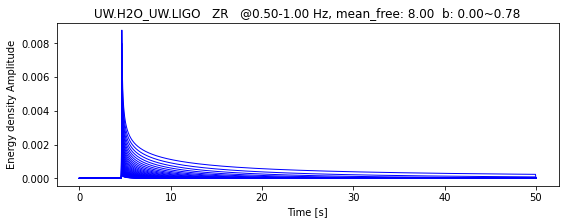

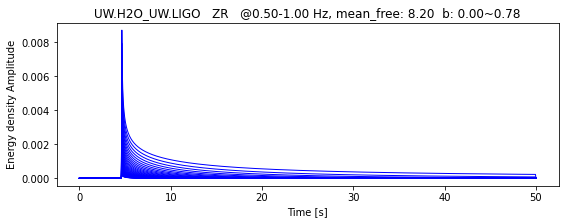

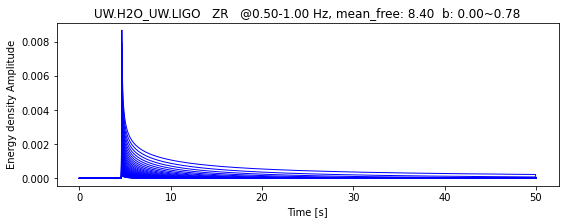

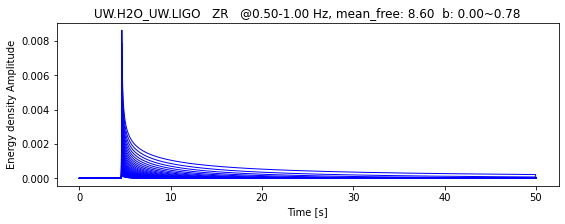

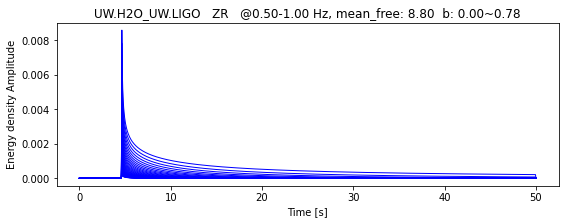

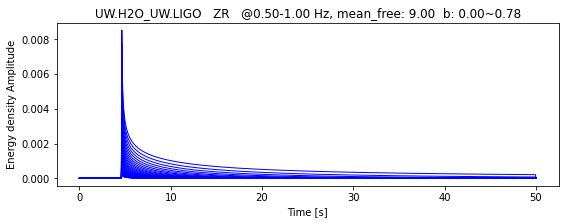

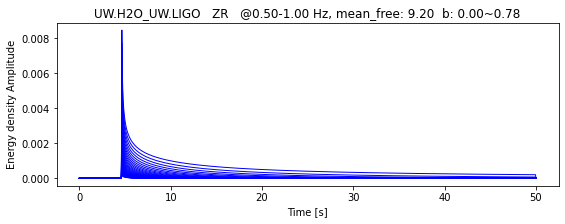

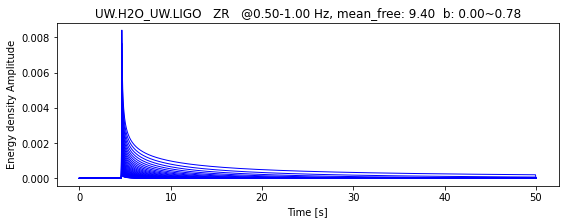

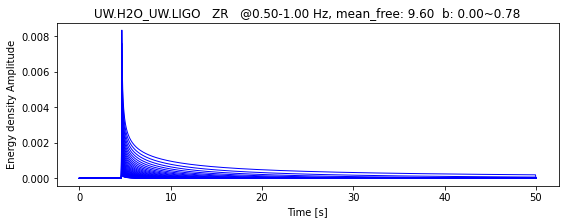

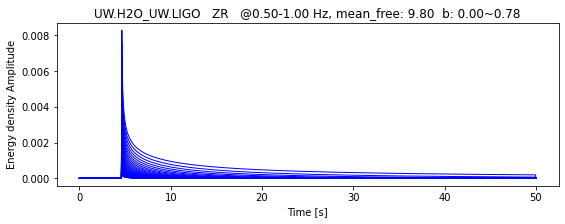

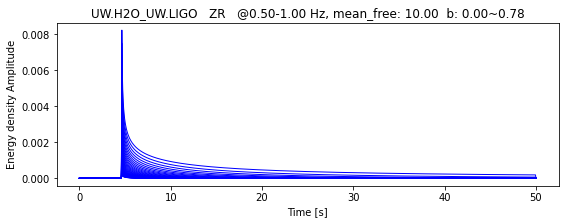

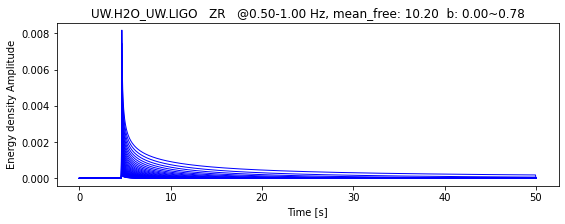

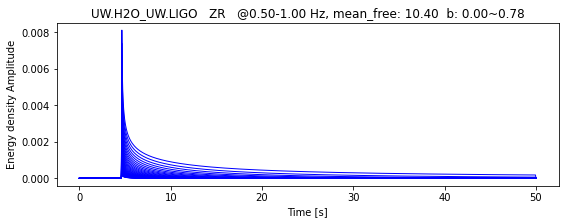

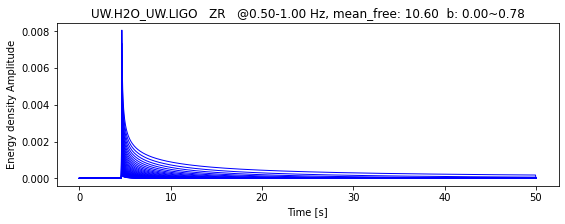

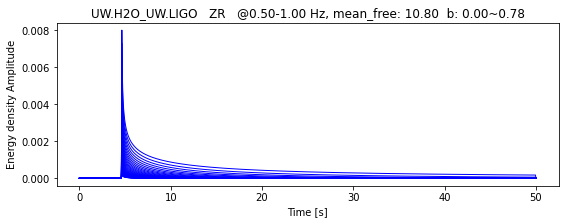

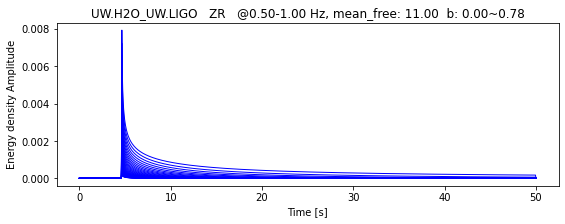

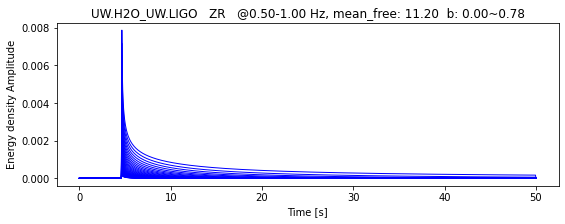

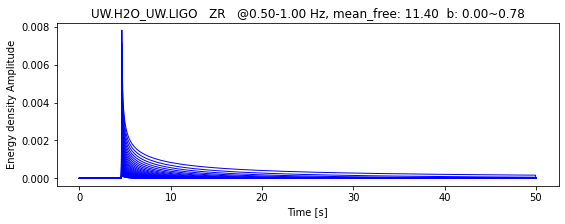

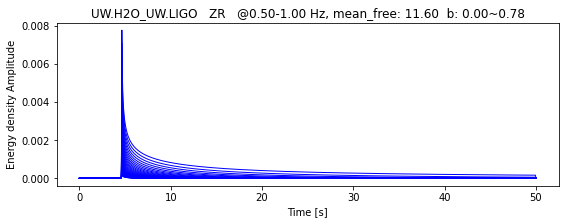

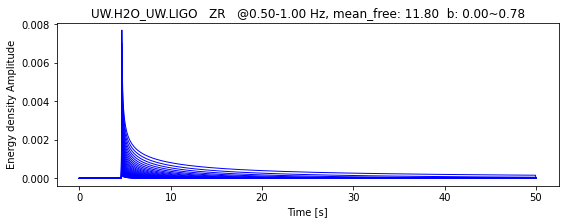

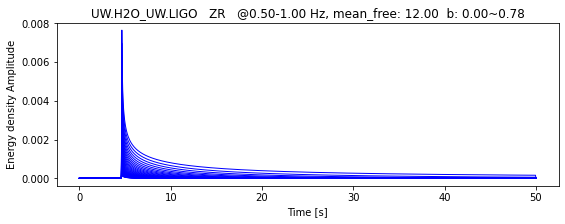

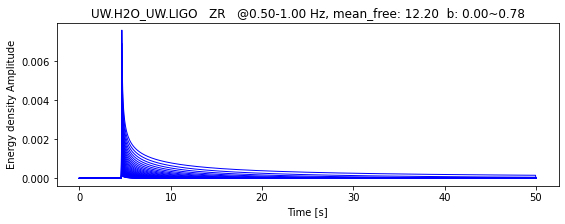

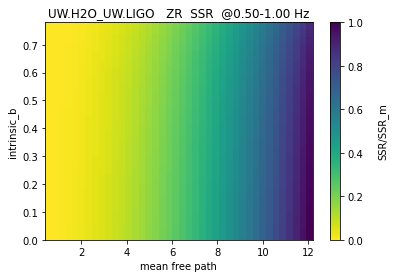

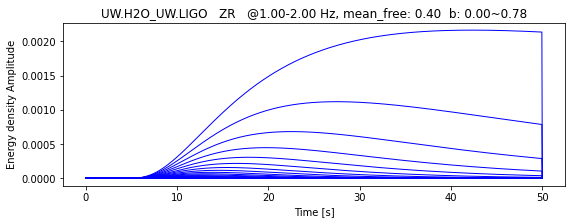

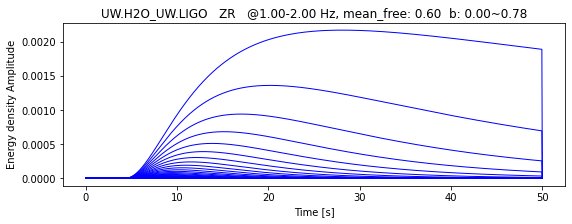

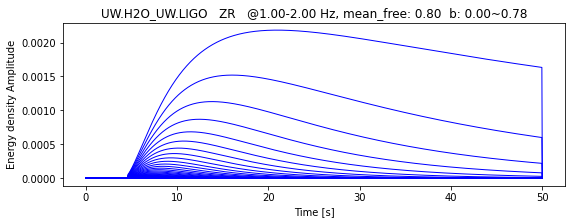

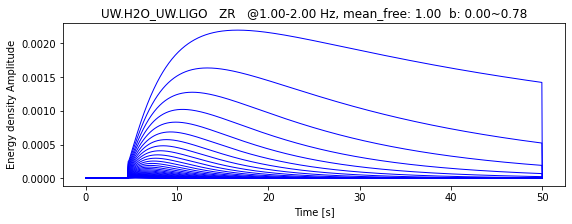

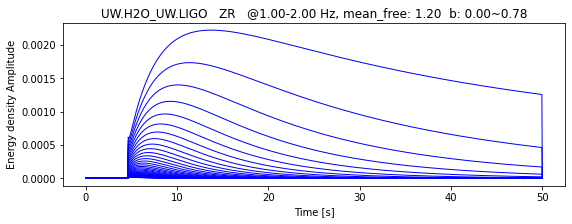

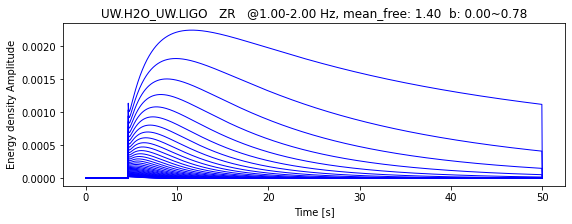

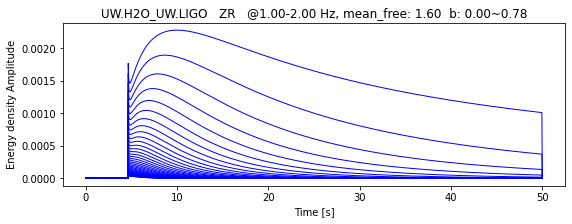

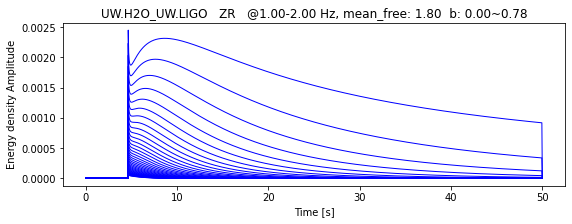

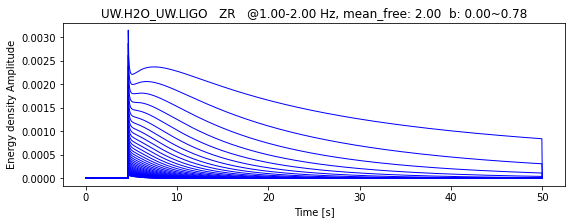

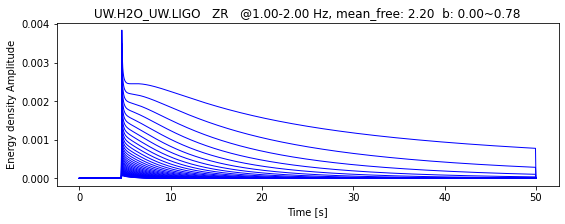

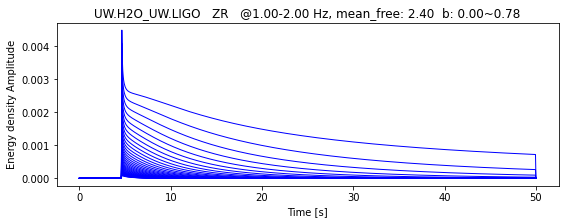

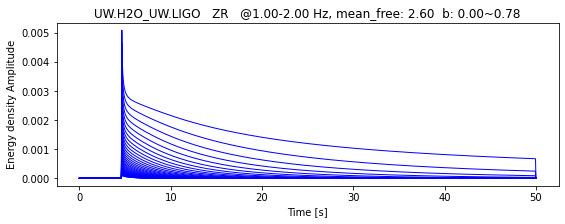

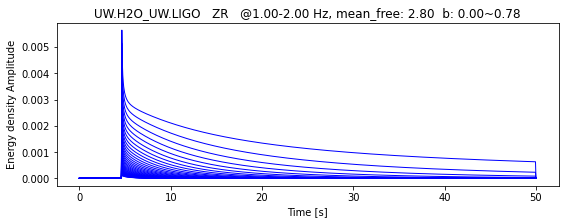

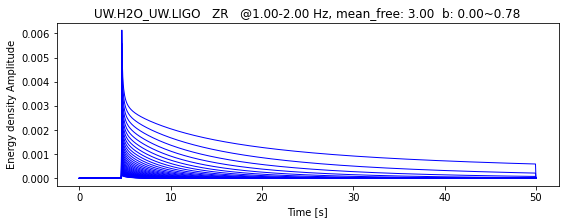

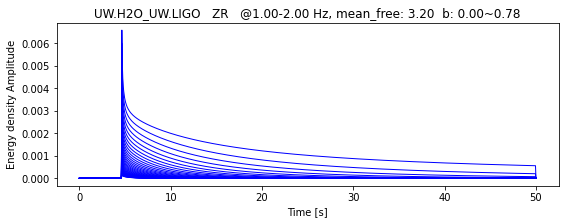

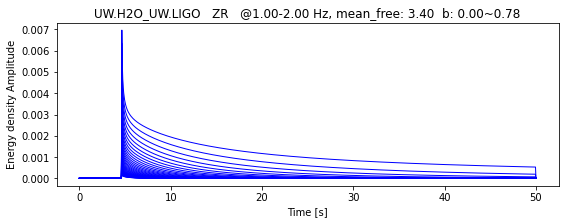

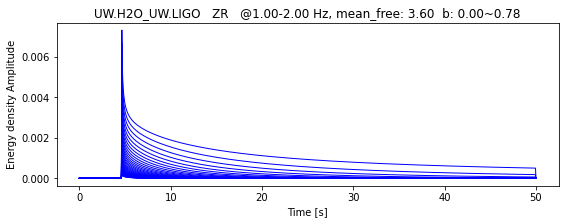

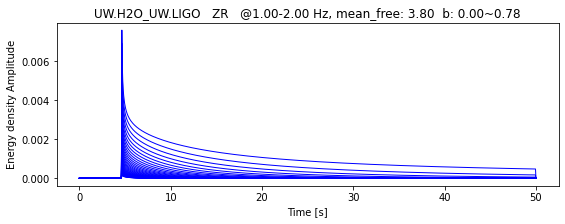

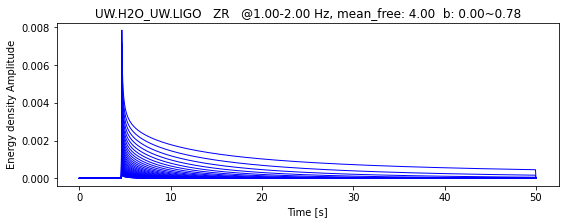

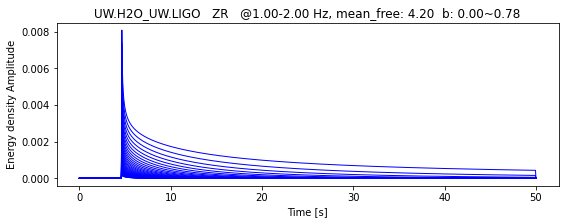

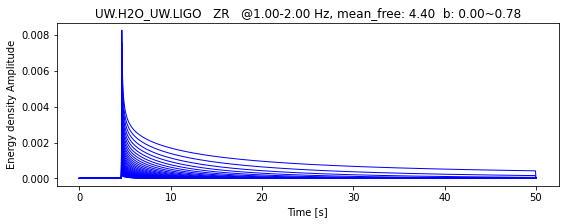

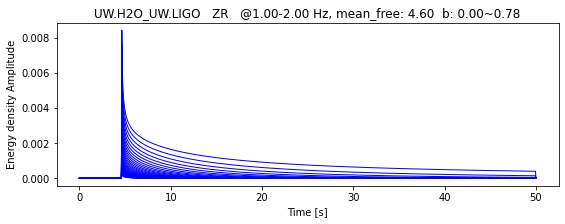

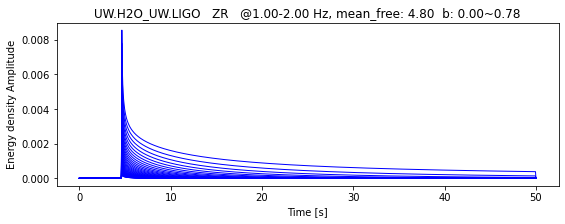

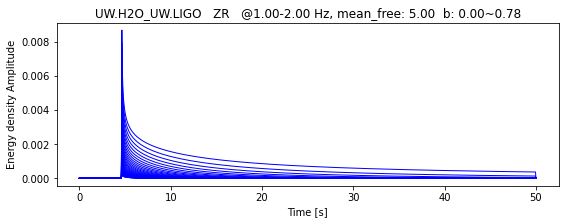

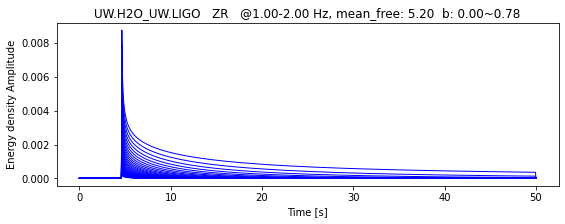

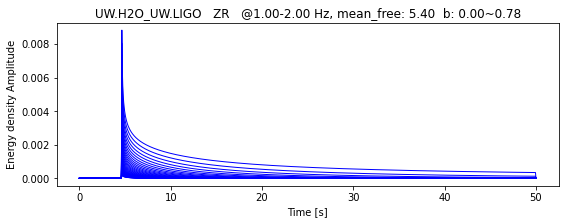

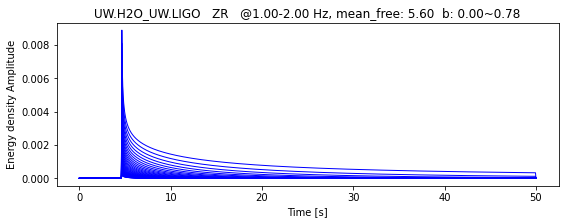

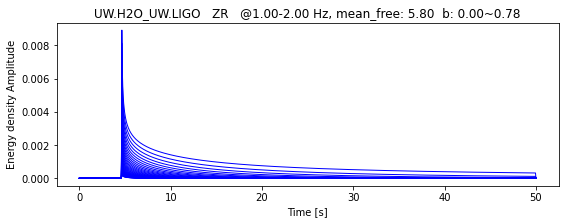

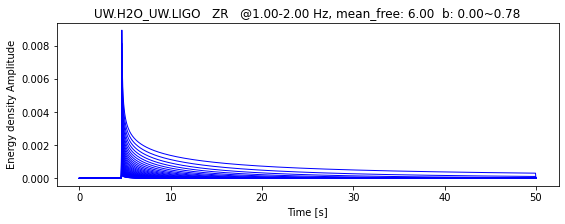

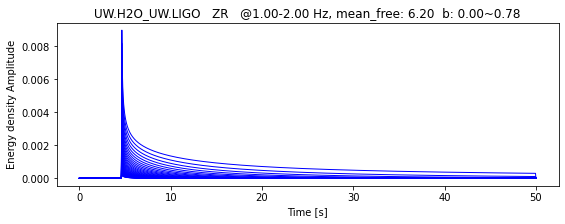

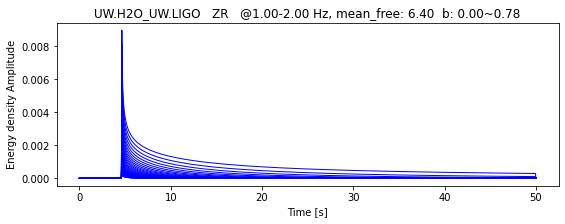

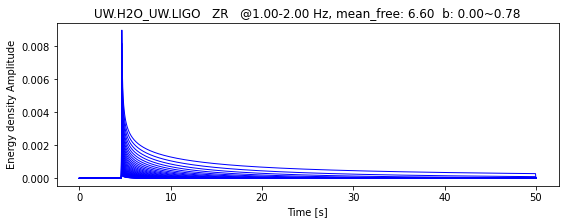

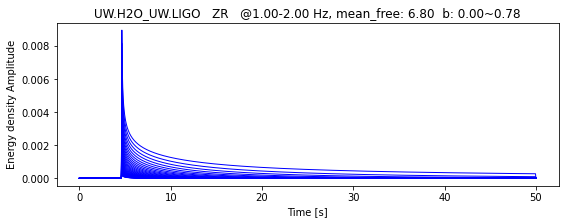

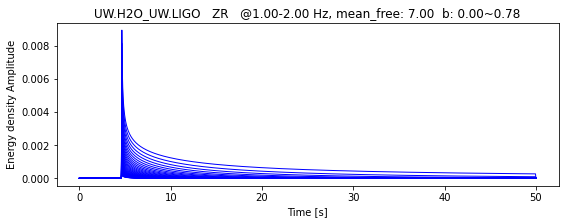

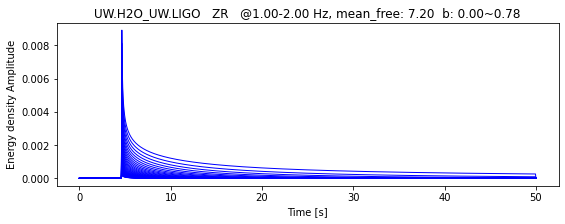

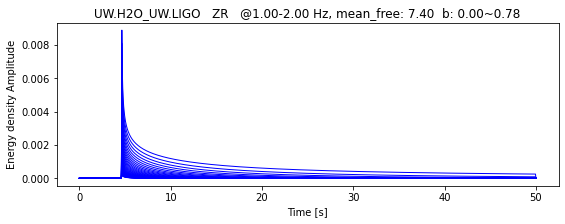

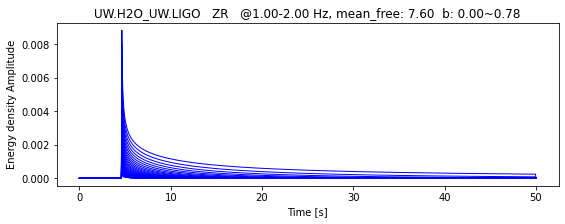

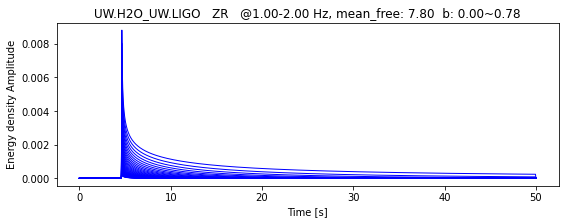

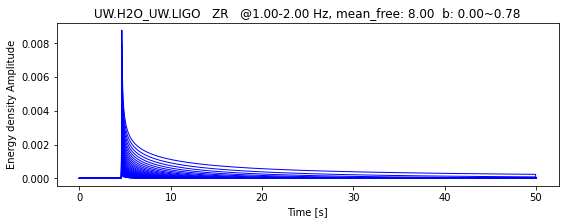

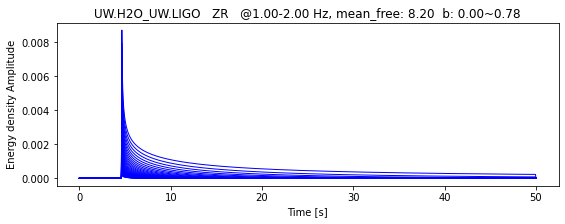

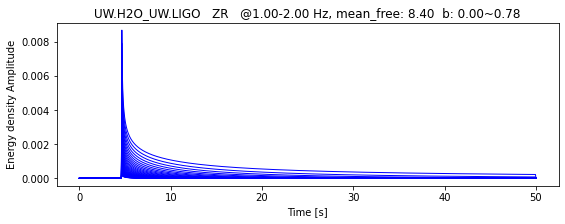

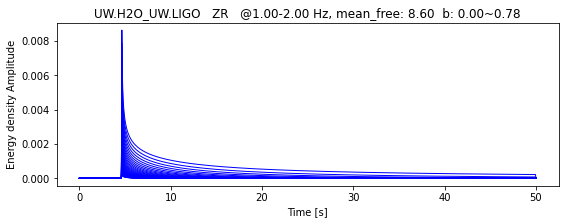

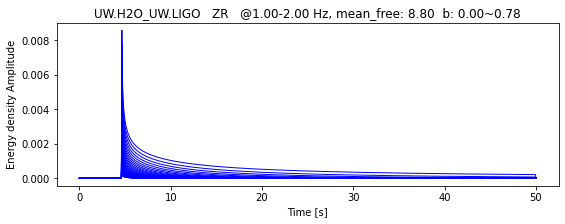

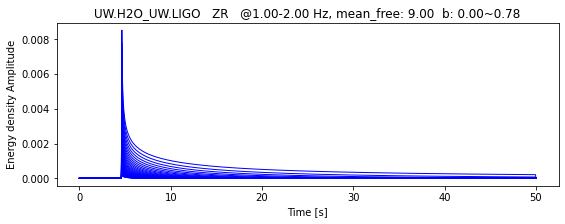

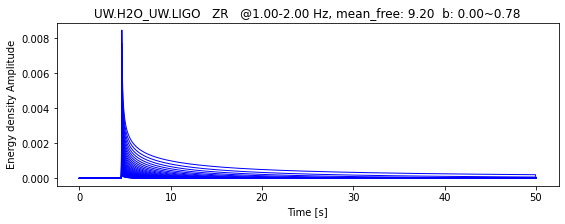

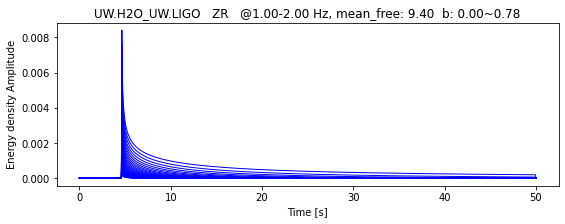

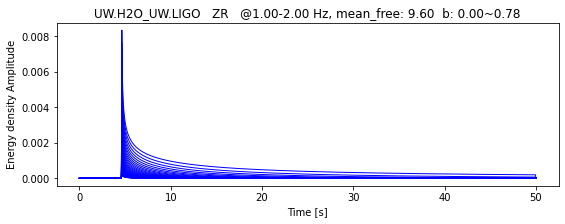

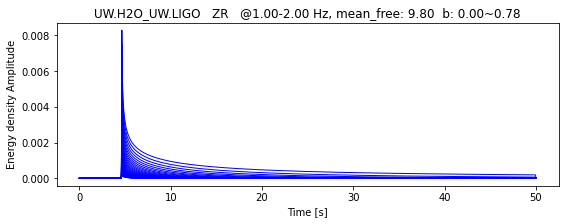

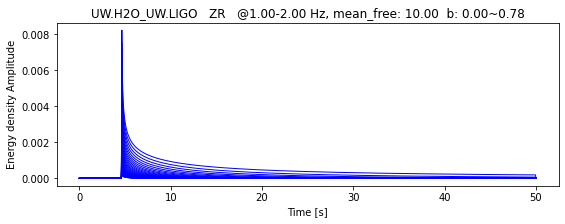

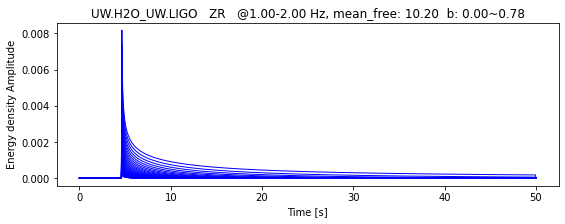

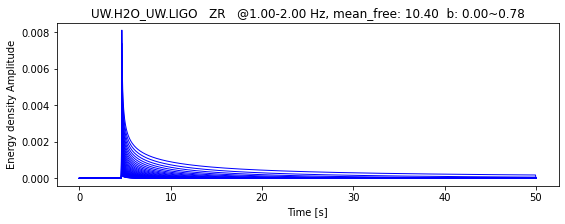

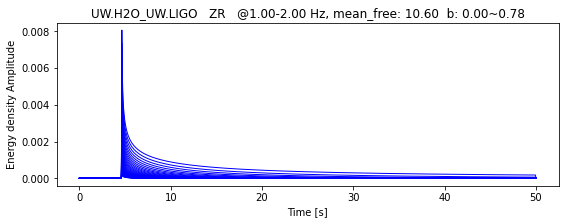

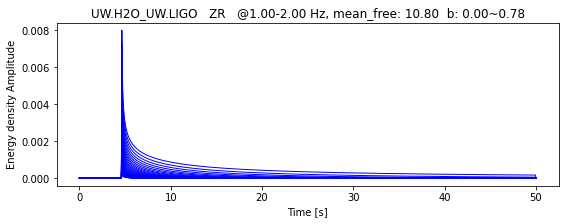

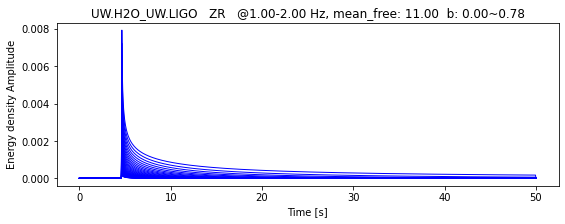

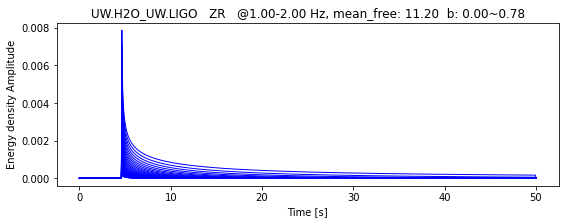

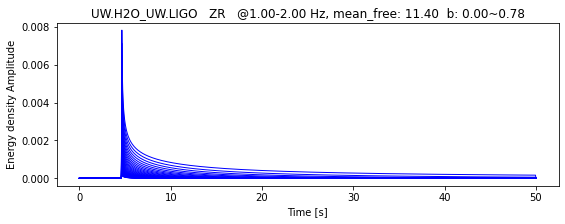

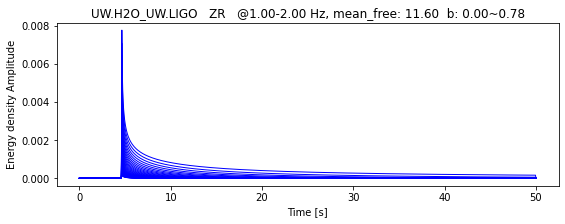

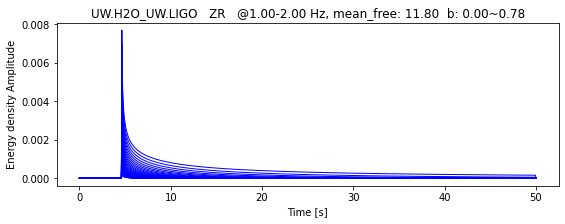

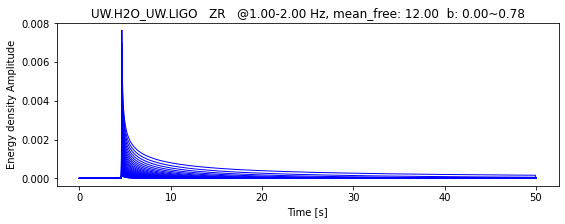

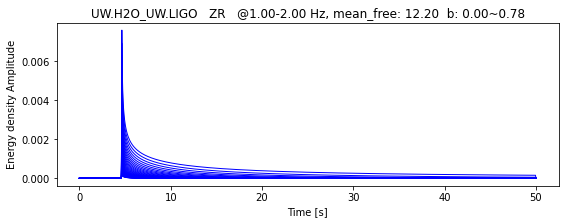

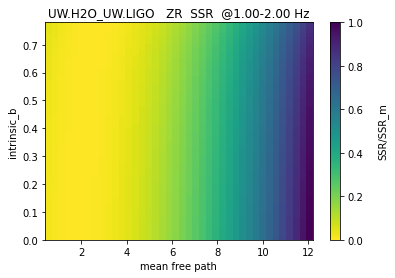

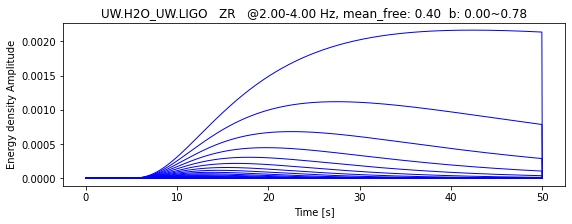

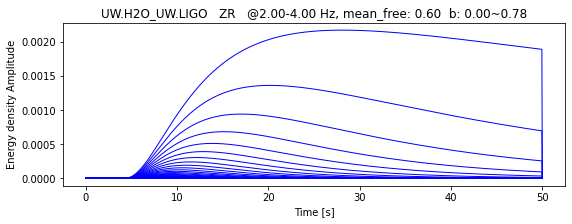

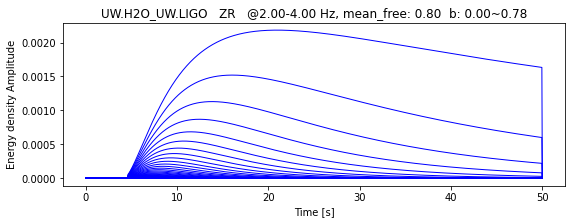

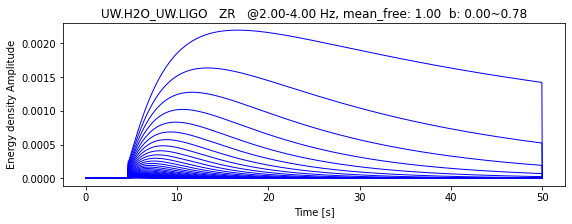

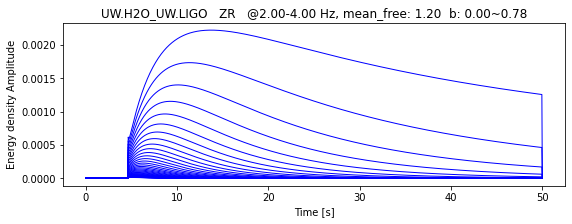

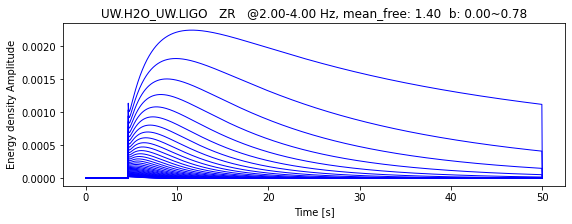

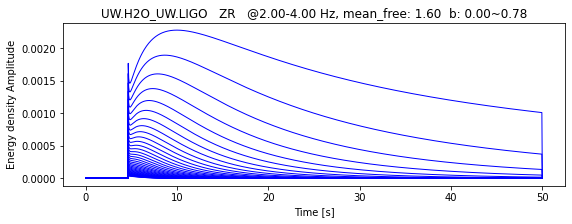

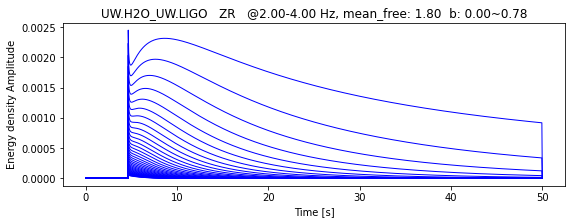

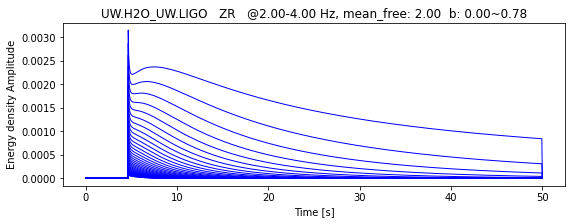

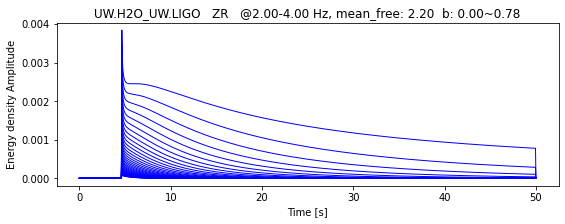

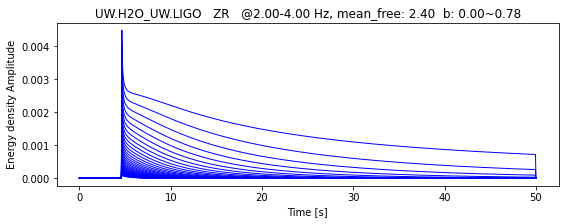

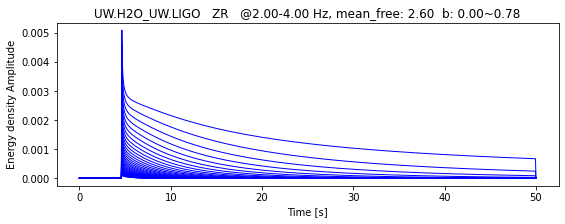

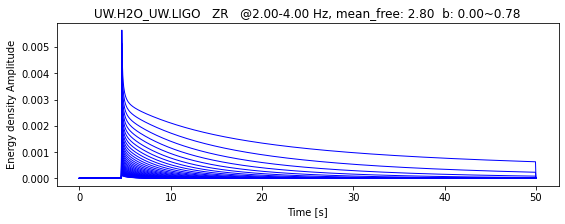

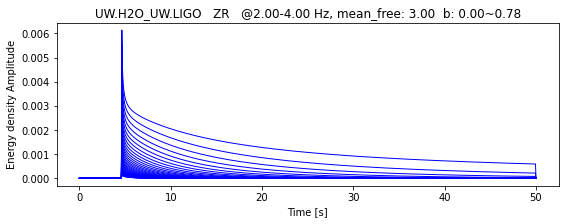

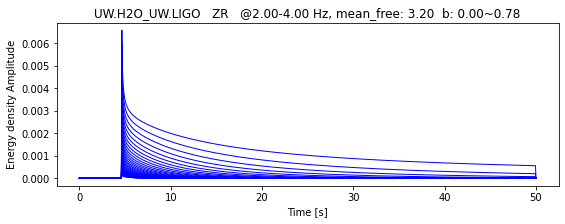

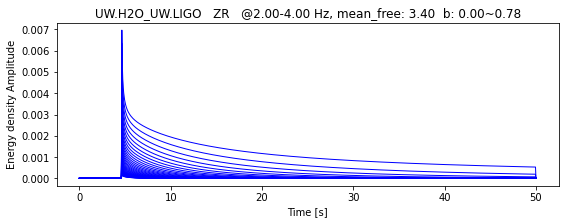

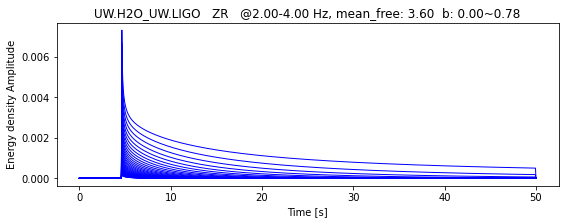

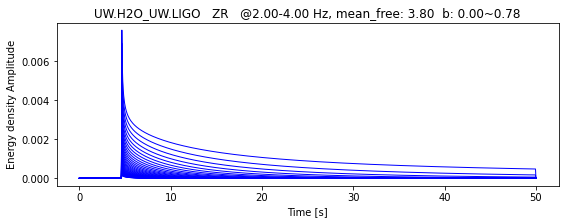

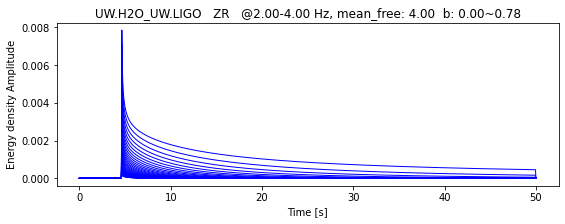

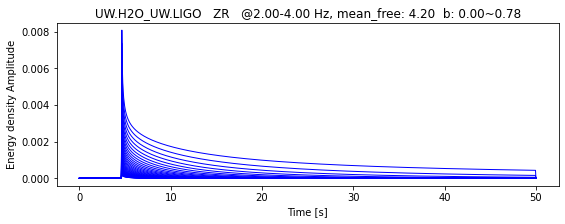

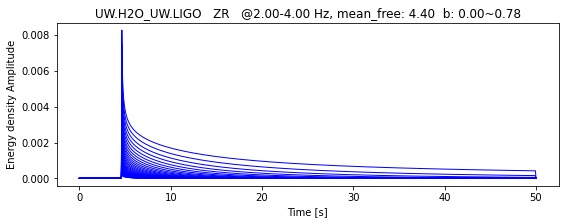

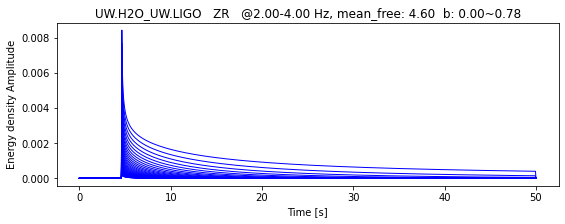

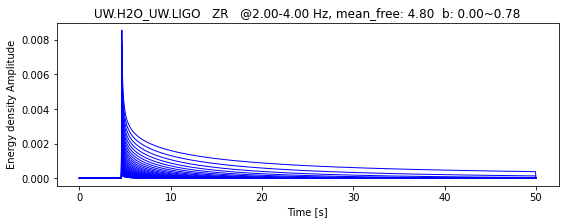

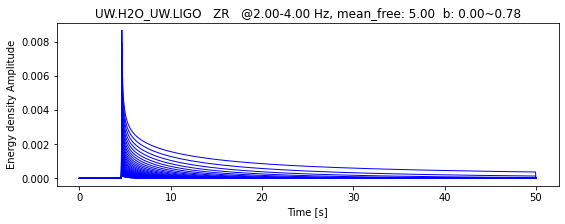

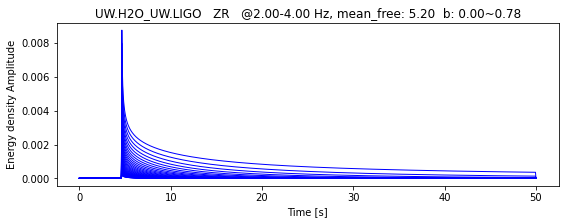

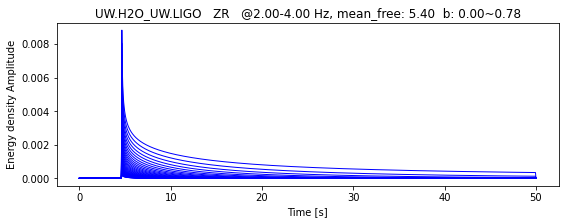

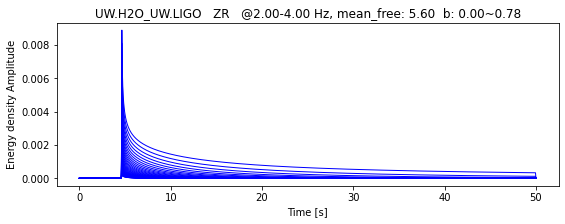

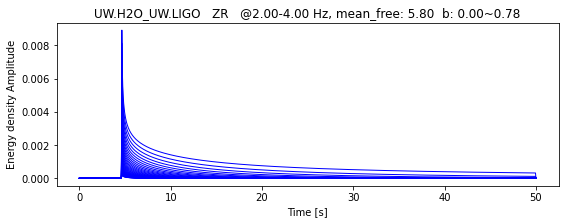

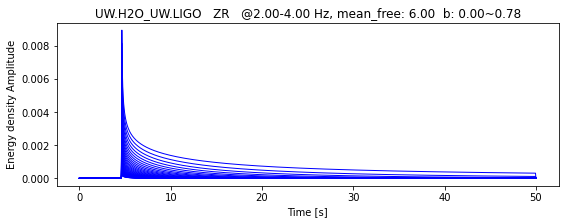

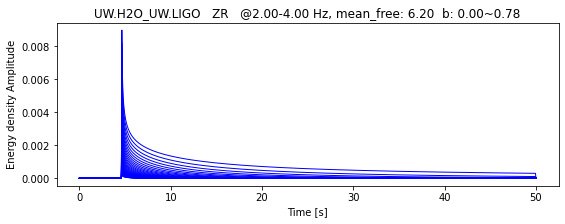

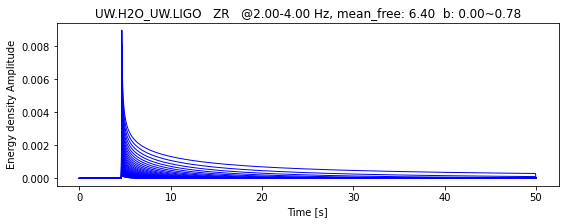

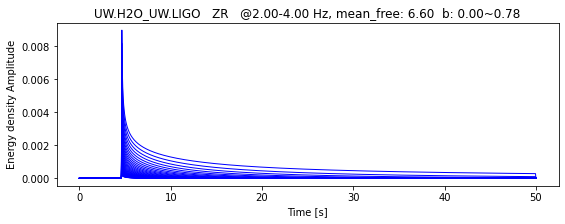

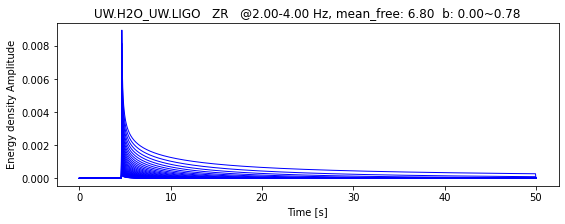

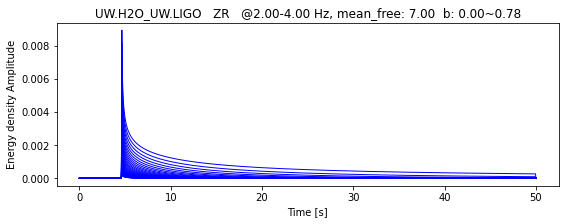

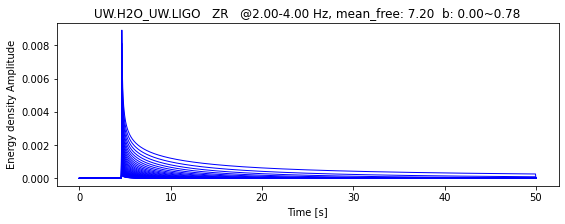

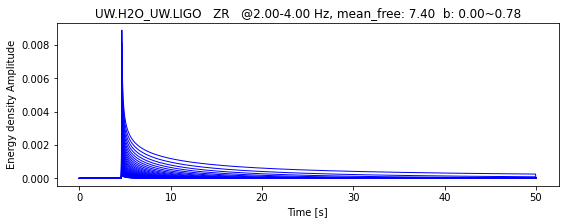

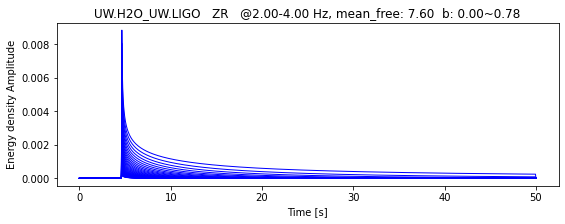

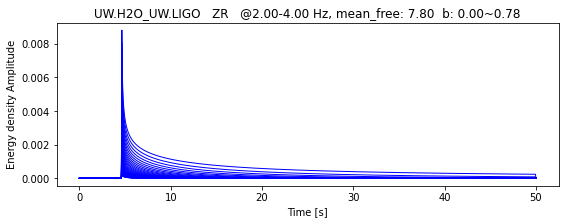

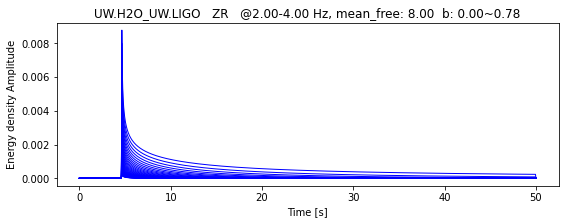

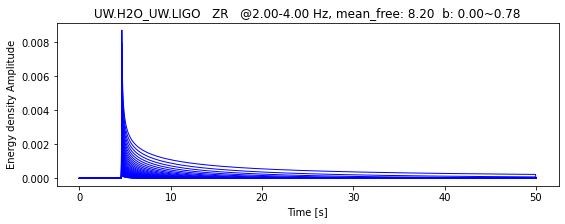

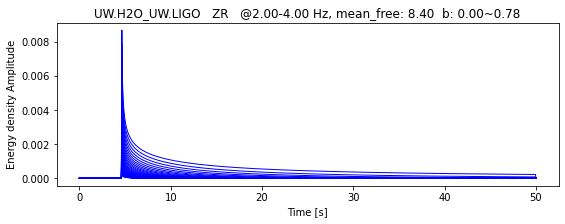

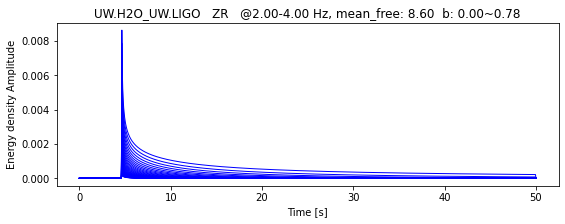

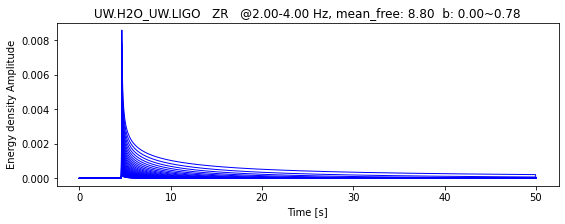

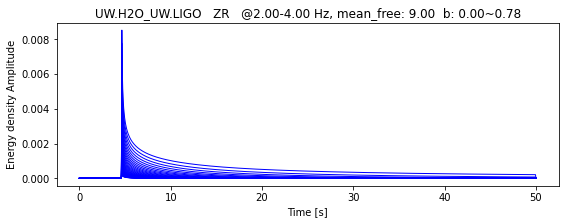

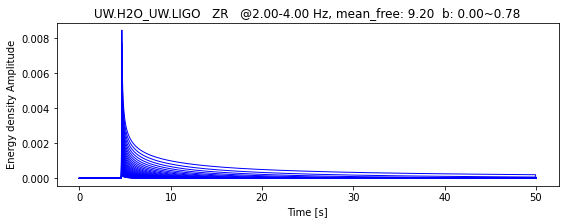

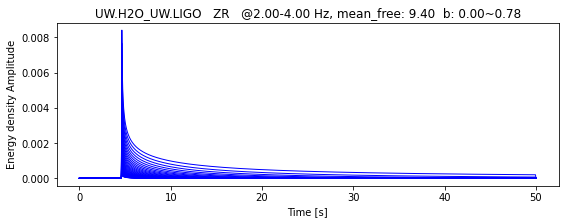

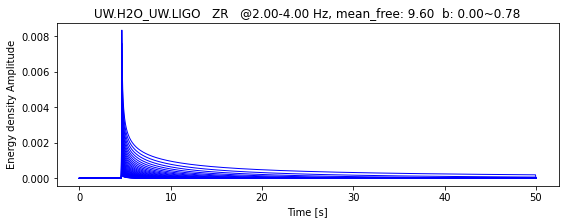

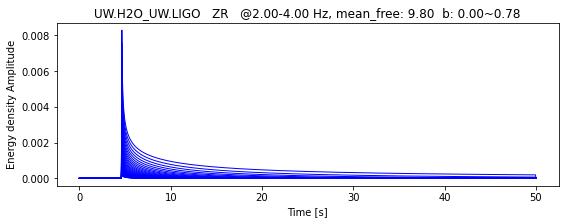

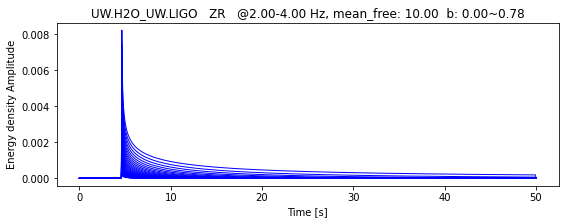

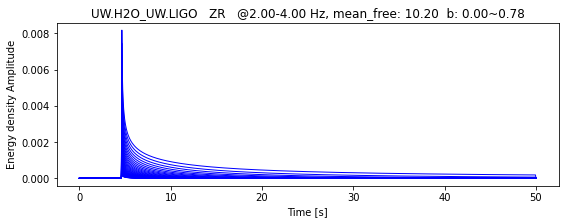

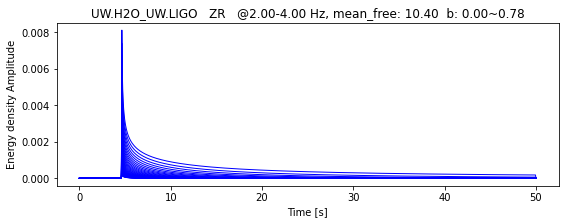

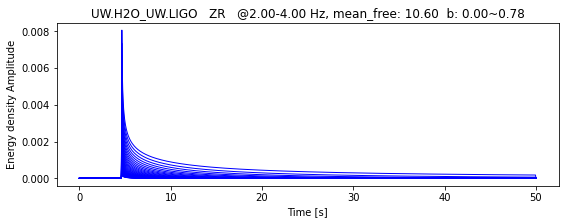

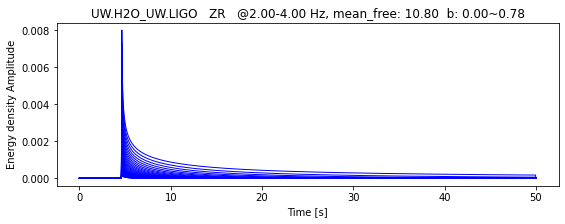

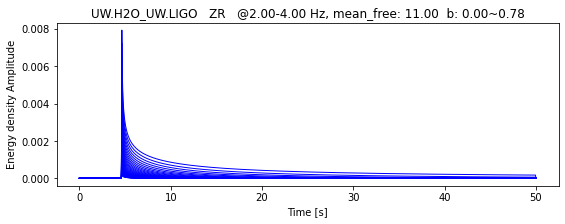

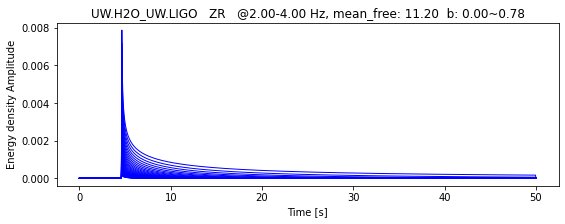

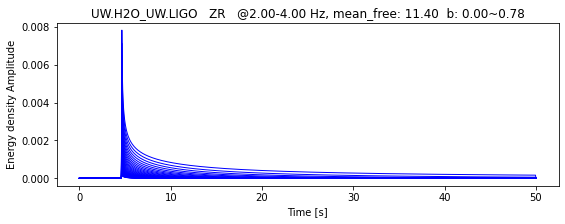

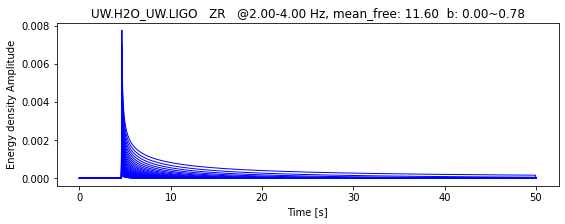

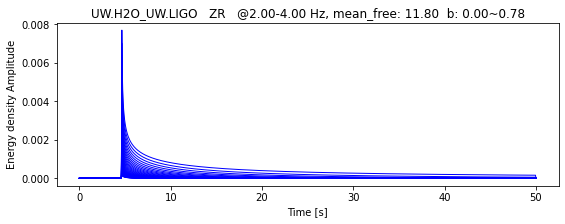

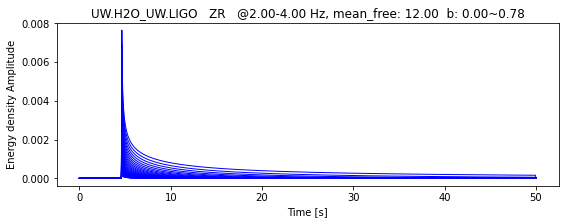

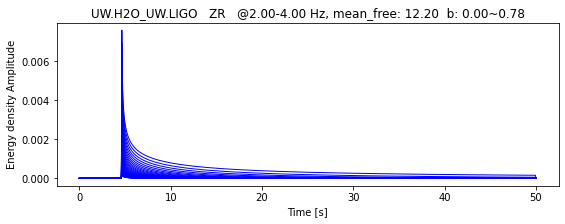

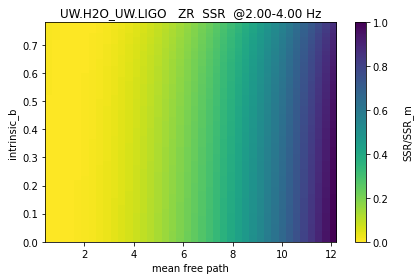

In [20]:
### haven't used multiple components but one.

x=np.zeros(60)    # mean_free_path search array
y=np.zeros(40)     # intrinsic_b search array
SSR=np.ndarray((fnum,nfreq,len(x),len(y)))
SSR[:][:][:][:]=0.
Esyn=np.ndarray((fnum,nfreq+1,len(x),len(y)))
Esyn[:][:][:][:]=0.

#tstep=[5.24, 5.74, 6.24, 36.1, 37.1, 37.6]  # time windows   --> should be determined depended on station pair 
c=1.6                                       # phase velocity --> should be vary

Esyn_temp=np.ndarray((len(x),len(y),npts//2+1))
Eobs_temp=np.ndarray((len(x),len(y),npts//2+1))

#for aa in range(fnum):
for aa in range(1):
    r=float(vdist[aa])
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        
        # grid search in combination of mean_free_path and intrinsic_b
        Esyn_temp[:][:][:]=0.
        Eobs_temp[:][:][:]=0.
        for nfree in range(len(x)):
            mean_free= 0.4+ 0.2 *nfree
            x[nfree]=mean_free
            
            plt.figure(figsize=(9, 3))
            for nb in range(len(y)):
                intrinsic_b=0.02*nb
                y[nb]=intrinsic_b
                
                # calculate the Esyn and SSR for combination of mean_free_path and intrinsic_b
                SSR_temp=0.
                
                for twn in range(npts//2):
                    tm=dt*twn
                    Eobs_temp[nfree][nb][twn]= msv[aa][fb+1][twn]
                    
                    s0=c**2 * tm**2 -r**2
                    if s0 < 0:
                        #print(twn,tm,s0)
                        continue
                        
                    tmp=ESYN_RadiaTrans(mean_free, tm , r, c)
                    Esyn_temp[nfree][nb][twn]= tmp * math.exp(-1* intrinsic_b * tm)                  
                    #print("tm",tm,twn,"Eobs %.2e " % msv[aa][fb+1][twn],"call ESYN  %.2e " % tmp,
                    #      " Esyn  %.2e " % Esyn_temp[nfree][nb][twn],"Eobs %.2e " % Eobs_temp[nfree][nb][twn] )
         
                # entire lapse time 
                SSR_temp+=(math.log10(Eobs_temp[nfree][nb][twn]) - math.log10(Esyn_temp[nfree][nb][twn]))**2
                SSR[aa][fb][nfree][nb]=SSR_temp
                
                # specific window
                #print("mean_free: %.2f " % mean_free,", intrinsic_b %.2f " %  intrinsic_b,"SSR: %.4f" % SSR_temp)
            
            #plt.figure(figsize=(9, 3))
                #plt.plot( msv[aa][0][:], Eobs_temp[nfree][nb], "k-", linewidth=1)
                plt.plot( msv[aa][0][:], Esyn_temp[nfree][nb], "b-", linewidth=1)
            plt.title("%s   %s   @%4.2f-%4.2f Hz, mean_free: %.2f  b: %.2f~%.2f"
                % ( fname[aa].split(".h5")[0],ccomp,fmin,fmax,mean_free,y[0],y[-1]))
            plt.xlabel("Time [s]")
            plt.ylabel("Energy density Amplitude")
    
        SSR[aa][fb]= SSR[aa][fb] / np.max(SSR[aa][fb][:][:])
        #SSR[aa][fb]= SSR[aa][fb] / np.min(SSR[aa][fb][:][:])
        
        plt.figure(figsize=(6,4))
        grid = SSR[aa][fb] #.reshape((len(x), len(y)))
        plt.title("%s   %s  SSR  @%4.2f-%4.2f Hz"
                  % (
                    fname[aa].split(".h5")[0],ccomp,fmin,fmax,
                    )
                )
        plt.xlabel("mean free path")
        plt.ylabel("intrinsic_b")
        im=plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),aspect='auto',cmap = 'viridis_r' )
        cb=plt.colorbar(im) #, mpl.cm.ScalarMappable(norm=norm)
        plt.clim(0,np.max(SSR[aa][fb][:][:]))
        #print(np.unravel_index(np.min(SSR[aa][fb]),SSR[aa][fb].shape),SSR[aa][fb].shape)
        print(aa,fb,SSR.shape, np.max(SSR[aa][fb]),np.min(SSR[aa][fb]) , np.argmin(np.min(SSR[aa][fb])))
        #plt.plot(,"+")
        cb.set_label('SSR/SSR_m', rotation=90, labelpad=14)
        
plt.tight_layout()
plt.show()     


### Step 5 --- Determination of best-fit parameters 